# Exploration and Modeling of Sampled 2013 NYC Taxi Trip and Fare Dataset in Spark 2.0 

#### Last updated:
January 17, 2017

---------------------------------
### Here we show some features and capabilities of Spark's MLlib toolkit for ML problems using the NYC taxi trip and fare data-set from 2013. We take a 0.1% sample of this data-set (about 170K rows, 35 Mb) to to show MLlib's modeling features for binary classification and regression problems using this data-set. We have shown relevant plots in Python.

Depeding on the size of your DSVM, this notebook may take about 2-4 mins to run.

----------------------------------

### OBJECTIVE: Show use of Spark MLlib's functions for data exploration, visualization, and ML tasks.

We have shown data ingestion, exploration and plotting, data preparation (featurizing/transformation), modeling, prediction, model persistance and model evaluation on an independent validation data-set. For plotting purposes, the Spark dataframes are converted to pandas dataframes so matplotlib functions can be used. This is because, there are no good Spark libraries for creating plots from Spark dataframes.

#### We address two machine learning problems:
1. Binary classification: Prediction of tip or no-tip (1/0) for a taxi trip [Using regularized regression]
2. Regression problem: Prediction of the tip amonut ($) [Using random forest]


### Introductory material

We previously published a walkthrough to be run on HDInsight Spark 1.6 clusters with the same NYC 2013 Taxi data:
http://www.andresmh.com/nyctaxitrips/
https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/

This may help some users to get familiarized with the NYC data-set.

## Set directory paths for input and output

In [14]:
# 1. Location of training data on 
taxi_train_file_loc = "../Data/JoinedTaxiTripFare.Point1Pct.Train.csv"
taxi_valid_file_loc = "../Data/JoinedTaxiTripFare.Point1Pct.Valid.csv"

# 2. Set model storage directory path. This is where models will be saved.
modelDir = "../Outputs/"; # The last backslash is needed;

## Set spark context and import necessary libraries

In [15]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import BinaryClassificationMetrics, RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, RFormula
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np
import datetime
import atexit
from sklearn.metrics import roc_curve,auc

sqlContext = SQLContext(sc)

<a name="ingestion"></a>
## Data ingestion: Read in joined 0.1% taxi trip and fare file (as tsv), format and clean data, and create data-frame

The taxi trip and fare files were joined based on the instructions provided in a walkthrough that we published previously: 
"https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-process-hive-walkthrough/"

A 0.1% sample of the joined data-set was taken to show the ML examples in this walkthrough.

In [16]:
## READ IN DATA AND CREATE SPARK DATAFRAME FROM A CSV
taxi_train_df = spark.read.csv(path=taxi_train_file_loc, header=True, inferSchema=True)

## CREATE A CLEANED DATAFRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
taxi_df_train_cleaned = taxi_train_df.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') \
        AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 200 \
        AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200" )

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_train_cleaned.createOrReplaceTempView("taxi_train")

<a name="exploration"></a>
## Data exploration & visualization: Plotting of target variables and features

### Summarize or filter data using SQL and plotting

#### Plot histogram of tip amount, relationship between tip amount vs. other features

For plotting, the dataframe will first have to be converted to a pandas dataframe, so matplotlib can use it for generating plots. Here, if the Spark dataframe is large, it can be down-sampled (using the "sample" function). In the example below, 50% of data was sampled, before converting the dataframe to a pandas dataframe.

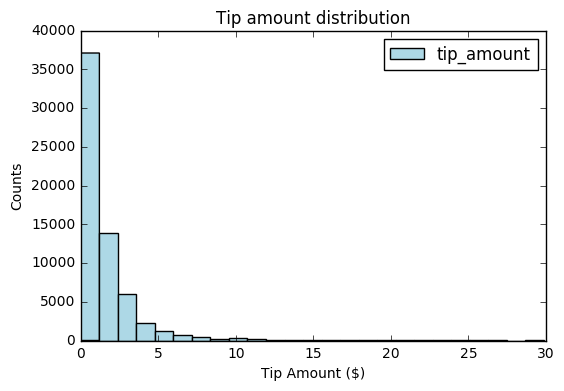

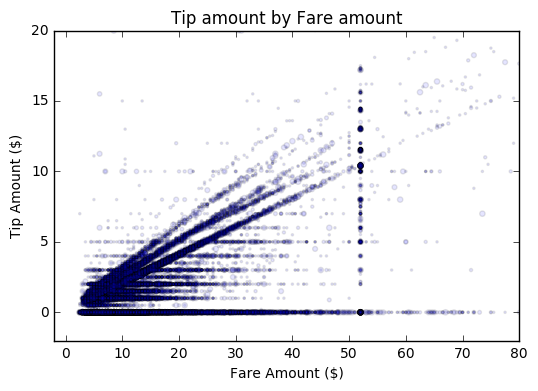

In [17]:
sqlStatement = """
    SELECT fare_amount, passenger_count, tip_amount, tipped FROM taxi_train
"""
sqlResultsPD = spark.sql(sqlStatement).sample(False, 0.5, seed=1234).toPandas();

%matplotlib inline
# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResultsPD[['tip_amount']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

# TIP AMOUNT BY FARE AMOUNT, POINTS ARE SCALED BY PASSENGER COUNT
ax = sqlResultsPD.plot(kind='scatter', x= 'fare_amount', y = 'tip_amount', c='blue', alpha = 0.10, s=2.5*(sqlResultsPD.passenger_count))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)'); ax.set_ylabel('Tip Amount ($)');
plt.axis([-2, 80, -2, 20])
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

<a name="transformation"></a>
## Feature engineering, transformation and data prep for modeling

#### Create a new feature by binning hours into traffic time buckets using Spark SQL

Spark SQL can be a very convenient way to perform pre-modeling steps, including data transformation, clean-up etc.

In [18]:
### CREATE FOUR BUCKETS FOR TRAFFIC TIMES
sqlStatement = """ SELECT *, CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_train 
"""
taxi_df_train_with_newFeatures = spark.sql(sqlStatement)

#### Indexing and one-hot encoding of categorical features

Here we only transform a few variables to show examples, which are character strings. Other variables, such as week-day, which are represented by numerical valies, can also be indexed as categorical variables.

For indexing, we used stringIndexer, and for one-hot encoding, we used OneHotEncoder functions from MLlib.

In [19]:
# DEFINE THE TRANSFORMATIONS THAT NEEDS TO BE APPLIED TO SOME OF THE FEATURES
sI1 = StringIndexer(inputCol="vendor_id", outputCol="vendorIndex"); en1 = OneHotEncoder(dropLast=False, inputCol="vendorIndex", outputCol="vendorVec");
sI2 = StringIndexer(inputCol="rate_code", outputCol="rateIndex"); en2 = OneHotEncoder(dropLast=False, inputCol="rateIndex", outputCol="rateVec");
sI3 = StringIndexer(inputCol="payment_type", outputCol="paymentIndex"); en3 = OneHotEncoder(dropLast=False, inputCol="paymentIndex", outputCol="paymentVec");
sI4 = StringIndexer(inputCol="TrafficTimeBins", outputCol="TrafficTimeBinsIndex"); en4 = OneHotEncoder(dropLast=False, inputCol="TrafficTimeBinsIndex", outputCol="TrafficTimeBinsVec");

# APPLY TRANSFORMATIONS
encodedFinal = Pipeline(stages=[sI1, en1, sI2, en2, sI3, en3, sI4, en4]).fit(taxi_df_train_with_newFeatures).transform(taxi_df_train_with_newFeatures)

#### Create a random sampling of the data, as needed (50% is used here). This can save time while training models. Then, split into train/test.

In [20]:
trainingFraction = 0.5; testingFraction = (1-trainingFraction);
seed = 1234;
encodedFinalSampled = encodedFinal.sample(False, 0.5, seed=seed)

# SPLIT SAMPLED DATAFRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
trainData, testData = encodedFinalSampled.randomSplit([trainingFraction, testingFraction], seed=seed);

# CACHE DATAFRAMES IN MEMORY
trainData.cache(); trainData.count();
testData.cache(); testData.count();

## Binary classification model training: Predicting tip or no tip (target: tipped = 1/0)

### Create logistic regression model, save modle, and evaluate performance of model on test data set

For modeling, the features and class labels are specified using the convenienct RFormula function

Area under ROC = 0.985992330764


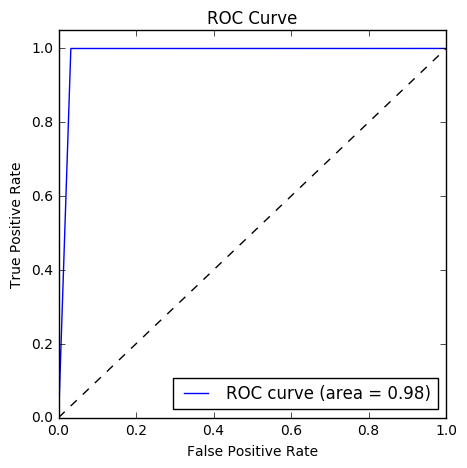

In [21]:
## TRAIN USING PIPELINE FORMULA + LOGISTIC REGRESSION ESTIMATOR
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

## DEFINE TRAINING FORMULA
classFormula = RFormula(formula="tipped ~ pickup_hour + weekday + passenger_count + trip_time_in_secs + trip_distance + fare_amount + vendorVec + rateVec + paymentVec + TrafficTimeBinsVec")

## TRAIN PIPELINE MODEL
model = Pipeline(stages=[classFormula, logReg]).fit(trainData)

## SAVE MODEL
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
fileName = "logisticRegModel_" + datestamp;
logRegDirfilename = modelDir + fileName;
model.save(logRegDirfilename)

## PREDICT ON TEST DATA AND EVALUATE
predictions = model.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

## PLOT ROC CURVE AFTER CONVERTING PREDICTIONS TO A PANDAS DATA FRAME
%matplotlib inline
predictions_pddf = predictions.toPandas()
labels = predictions_pddf["label"]
prob = []
for dv in predictions_pddf["probability"]:
    prob.append(dv.values[1])
    
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
plt.title('ROC Curve'); plt.legend(loc="lower right");
plt.show()

## Regression model training: Predicting amount of tip paid for taxi trips

### Train a random forest model regression model, save, and evaluate on test data set

For modeling, the features and class labels are specified using the convenienct RFormula function

RMSE = 0.966855340432
R-sqr = 0.694574331686


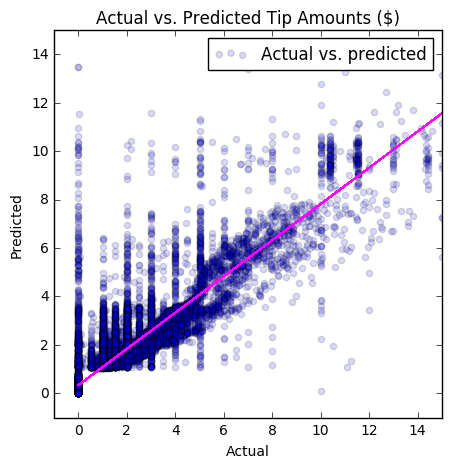

In [22]:
## DEFINE REGRESSION FURMULA
regFormula = RFormula(formula="tip_amount ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex + pickup_hour + weekday + passenger_count + trip_time_in_secs + trip_distance + fare_amount")

## DEFINE INDEXER FOR CATEGORIAL VARIABLES
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=32)

## DEFINE RANDOM FOREST ESTIMATOR
randForest = RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'label', numTrees=20, 
                                   featureSubsetStrategy="auto",impurity='variance', maxDepth=6, maxBins=100)

## Fit model, with formula and other transformations
model = Pipeline(stages=[regFormula, featureIndexer, randForest]).fit(trainData)

## SAVE MODEL
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
fileName = "RandomForestRegressionModel_" + datestamp;
randForestDirfilename = modelDir + fileName;
model.save(randForestDirfilename)

## PREDICT ON TEST DATA AND EVALUATE
predictions = model.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd
testMetrics = RegressionMetrics(predictionAndLabels)
print("RMSE = %s" % testMetrics.rootMeanSquaredError)
print("R-sqr = %s" % testMetrics.r2)

## PLOC ACTUALS VS. PREDICTIONS
predictionsPD = predictions.select("label","prediction").toPandas()

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.15, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('Actual vs. Predicted Tip Amounts ($)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
plt.axis([-1, 15, -1, 15])
plt.show(ax)

## Load a pipeline model and evaluate it test data

In [23]:
savedModel = PipelineModel.load(logRegDirfilename)

predictions = savedModel.transform(testData)
predictionAndLabels = predictions.select("label","prediction").rdd

metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.985992330764


## Hyper-parameter tuning: Train a random forest model using hyper-parameter tuning and cross-validation

Notice that as expected, the parameter tuning and cross-validation improves the model performance (R-sqr) significantly on test data.

In [24]:
## DEFINE RANDOM FOREST MODELS
randForest = RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'label', 
                                   featureSubsetStrategy="auto",impurity='variance', maxBins=100)

## DEFINE MODELING PIPELINE, INCLUDING FORMULA, FEATURE TRANSFORMATIONS, AND ESTIMATOR
pipeline = Pipeline(stages=[regFormula, featureIndexer, randForest])

## DEFINE PARAMETER GRID FOR RANDOM FOREST
paramGrid = ParamGridBuilder() \
    .addGrid(randForest.numTrees, [10, 25, 50]) \
    .addGrid(randForest.maxDepth, [3, 5, 7]) \
    .build()

## DEFINE CROSS VALIDATION
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(metricName="rmse"),
                          numFolds=3)

## TRAIN MODEL USING CV
cvModel = crossval.fit(trainData)

## PREDICT AND EVALUATE TEST DATA SET
predictions = cvModel.transform(testData)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)

## SAVE THE BEST MODEL
fileName = "CV_RandomForestRegressionModel_" + datestamp;
CVDirfilename = modelDir + fileName;
cvModel.bestModel.save(CVDirfilename);

R-squared on test data = 0.781712


## Load independent validation data-set and evaluate a model

The validation data-set needs to be transformed in the same way as the training data in order to score it correctly.

In [25]:
## READ IN DATA FRAME FROM CSV
taxi_valid_df = spark.read.csv(path=taxi_valid_file_loc, header=True, inferSchema=True)

## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
taxi_df_valid_cleaned = taxi_valid_df.drop('medallion').drop('hack_license').drop('store_and_fwd_flag').drop('pickup_datetime')\
    .drop('dropoff_datetime').drop('pickup_longitude').drop('pickup_latitude').drop('dropoff_latitude')\
    .drop('dropoff_longitude').drop('tip_class').drop('total_amount').drop('tolls_amount').drop('mta_tax')\
    .drop('direct_distance').drop('surcharge')\
    .filter("passenger_count > 0 and passenger_count < 8 AND payment_type in ('CSH', 'CRD') \
        AND tip_amount >= 0 AND tip_amount < 30 AND fare_amount >= 1 AND fare_amount < 200 \
        AND trip_distance > 0 AND trip_distance < 100 AND trip_time_in_secs > 30 AND trip_time_in_secs < 7200")

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
taxi_df_valid_cleaned.createOrReplaceTempView("taxi_valid")

### CREATE FOUR BUCKETS FOR TRAFFIC TIMES
sqlStatement = """ SELECT *, CASE
     WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN "Night" 
     WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN "AMRush" 
     WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN "Afternoon"
     WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN "PMRush"
    END as TrafficTimeBins
    FROM taxi_valid
"""
taxi_df_valid_with_newFeatures = spark.sql(sqlStatement)

## APPLY THE SAME TRANSFORATION ON THIS DATA AS ORIGINAL TRAINING DATA
encodedFinalValid = Pipeline(stages=[sI1, en1, sI2, en2, sI3, en3, sI4, en4]).fit(taxi_df_train_with_newFeatures).transform(taxi_df_valid_with_newFeatures)

In [26]:
## LOAD SAVED MODEL, SCORE VALIDATION DATA, AND EVALUATE
savedModel = PipelineModel.load(CVDirfilename)
predictions = savedModel.transform(encodedFinalValid)
r2 = evaluator.evaluate(predictions)
print("R-squared on test data = %g" % r2)

R-squared on test data = 0.798719
